## Predict category that a post belongs to, based on its content.

In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

import itertools
from sklearn.metrics import confusion_matrix

def normalize(cnf):
    """
    Returns normalized confusion matrix
    """
    return cnf.astype('float') / cnf.sum(axis=1)[:, np.newaxis]

def plot_confusion_matrix(cnf, 
                          labels,
                          norm=False,
                          title='Confusion matrix',
                          colorbar=True,
                          cmap=plt.cm.OrRd,
                          xlabel='Predicted Labels',
                          ylabel='True Labels',
                          precision=1
                         ):
    """
    adapted from: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html 
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting norm=True.
    """
    #plt.figure()
    plt.figure(figsize=(8, 8))
    if norm: 
        cnf = normalize(cnf)
        
    art = plt.imshow(cnf, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=10)
    if colorbar:
        plt.colorbar(art,shrink=0.5).ax.tick_params(labelsize=7) 
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=90,fontsize=8)
    plt.yticks(tick_marks, labels,fontsize=8)

    thresh = cnf.max() / 2.
    for i, j in itertools.product(range(cnf.shape[0]), repeat=2):
        if cnf.dtype=='float':
            plt.text(j, i, '{0:0.{1}f}'.format(cnf[i, j],precision),
                 horizontalalignment="center",
                 verticalalignment="center",    
                 fontsize=5,
                 color="white" if cnf[i, j] > thresh else "black")
        else:
            plt.text(j, i, cnf[i, j],
                 horizontalalignment="center",
                 verticalalignment="center",    
                 fontsize=5,
                 color="white" if cnf[i, j] > thresh else "black")

    
    plt.ylabel(ylabel,fontsize=9)
    plt.xlabel(xlabel,fontsize=9)
    plt.tight_layout()
    plt.show()

In [2]:
df = pd.read_csv('../input/techcrunch_posts.csv')
df.head(3)

,authors,category,content,date,id,img_src,section,tags,title,topics,url
0,Dale Chang,Startups,\n\nTech investing isn’t what it used to be — ...,2016-10-15,1401293,https://tctechcrunch2011.files.wordpress.com/2...,startups/,data,How startups can use data to grow smarter,NaN,https://techcrunch.com/2016/10/15/how-startups...
1,"Ben Narasin,Jeremy Abelson",Fundings & Exits,\n\nThe IPO market is poised to make an almost...,2016-10-14,1399050,https://tctechcrunch2011.files.wordpress.com/2...,startups/,ipo,"While the IPO market roars back, venture remai...",NaN,https://techcrunch.com/2016/10/14/while-the-ip...
2,Matthew Lynley,Apps,Under pressure from shoppers complaining about...,2016-10-14,1401954,https://tctechcrunch2011.files.wordpress.com/2...,startups/,apoorva-mehta,"Instacart reverses course, re-introducing tips...",instacart,https://techcrunch.com/2016/10/14/instacart-re...


Exclude samples with no content or no category. Then inspect how many samples we have for each category.

In [3]:
df = df[(df.category.notnull() & df.content.notnull())]
df.category.value_counts()

Apps                         9383
Gadgets                      5101
Europe                       4784
Enterprise                   3254
Startups                     2967
Social                       2333
Asia                         1782
Mobile                       1550
eCommerce                    1427
Fundings & Exits             1222
Advertising Tech             1155
Education                     502
Media                         353
Cloud                         307
Developer                     300
Gaming                        260
Finance                       223
Opinion                       189
Entertainment                 175
Collaborative Consumption     151
Artificial Intelligence       135
Health                        123
Government                     93
Earnings                       68
Bio                            59
Diversity                      52
Automotive                     45
Drama                          43
Augmented Reality              38
TC            

Exclude categories that have too few samples (< min_samples). Remove punctuation from content.

In [4]:
min_samples=100
category_counts = df.category.value_counts()
df = df[df.category.isin(category_counts[category_counts > min_samples].index)]
df.content = df.content.apply(lambda x: ' '.join(re.sub(r'[^0-9a-zA-Z]',' ',str(x)).split()))

Convert category names into integer values (category_id).

In [5]:
labels = sorted(set(df.category.values))
print('%25s: %s\n%s'%('Category','ID','-'*29))
for idx,label in enumerate(labels):
    print('%25s: %-d'%(label,idx))

                 Category: ID
-----------------------------
         Advertising Tech: 0
                     Apps: 1
  Artificial Intelligence: 2
                     Asia: 3
                    Cloud: 4
Collaborative Consumption: 5
                Developer: 6
                Education: 7
               Enterprise: 8
            Entertainment: 9
                   Europe: 10
                  Finance: 11
         Fundings & Exits: 12
                  Gadgets: 13
                   Gaming: 14
                   Health: 15
                    Media: 16
                   Mobile: 17
                  Opinion: 18
                   Social: 19
                 Startups: 20
                eCommerce: 21


In [6]:
df['category_id'] = df.category.apply(lambda x: int(labels.index(x)))

Shuffle dataset and split into training (60%) and test (40%) sets.

In [7]:
df = df.reindex(np.random.permutation(df.index))

In [8]:
t_index = int(len(df)*0.6)
X_train = df.content.values[:t_index]
y_train = df.category_id.values[:t_index]

X_test = df.content.values[t_index:]
y_test = df.category_id.values[t_index:]

df_train = df.iloc[:t_index]
df_test = df.iloc[t_index:]

Classify using Linear SVC.

In [9]:
classifier = Pipeline([
    ('vect', CountVectorizer(stop_words='english',max_df=0.5,ngram_range=(1,3),max_features=10000)),
    ('tfidf', TfidfTransformer(sublinear_tf=True,norm='l2',use_idf=True)),
    ('clf', LinearSVC(loss='squared_hinge',multi_class='ovr',dual=True,tol=0.001,class_weight='balanced')),
])
_ = classifier.fit(X_train, y_train)

Predict categories on the test set and print confusion matrix.

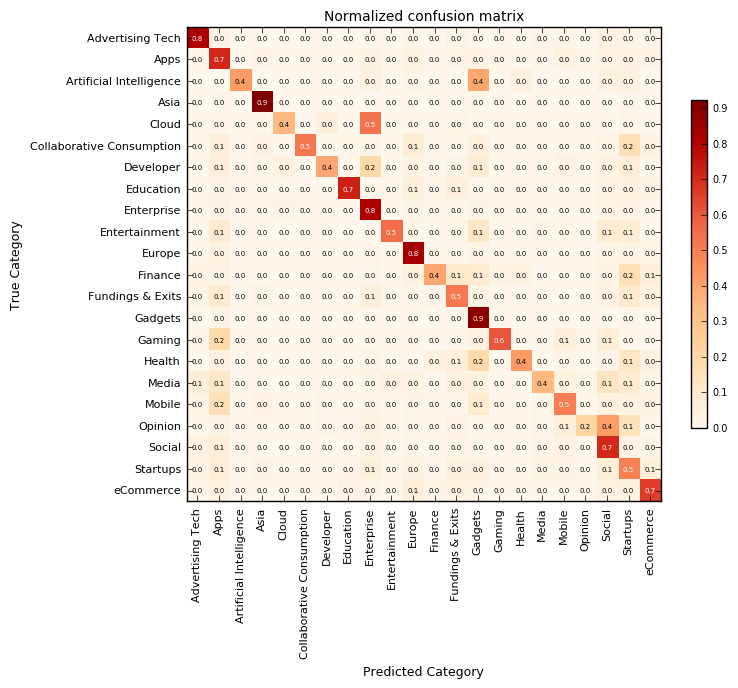

In [10]:
predicted = classifier.predict(X_test)
plot_confusion_matrix(confusion_matrix(y_test,predicted), 
                      labels=labels, 
                      norm=True,
                      title='Normalized confusion matrix',
                      xlabel='Predicted Category',
                      ylabel='True Category',
                      precision=1
                     )